# Tracking mutation frequencies

In [1]:
%matplotlib inline
%pylab inline
import fwdpy as fp
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

Populating the interactive namespace from numpy and matplotlib


## Run a simulation

In [2]:
nregions = [fp.Region(0,1,1),fp.Region(2,3,1)]
sregions = [fp.ExpS(1,2,1,-0.1),fp.ExpS(1,2,0.01,0.001)]
rregions = [fp.Region(0,3,1)]
rng = fp.GSLrng(201)
popsizes = np.array([1000],dtype=np.uint32)
popsizes=np.tile(popsizes,10000)
#Initialize a vector with 1 population of size N = 1,000
pops=fp.popvec(1,1000)
#Record mutation frequencies every generation
traj = [pd.DataFrame(i) for i in fp.evolve_regions_track(rng,pops,popsizes[0:],0.001,0.001,0.001,nregions,sregions,rregions,1)]

## Group mutation trajectories by position and effect size

#### Max mutation frequencies


In [3]:
mfreq = traj[0].groupby(['pos','esize']).max().reset_index()
#Print out info for all mutations that hit a frequency of 1 (e.g., fixed)
mfreq[mfreq['freq']==1]

,pos,esize,freq,generation
16467,1.817526,0.001171,1,4587


The only fixation has an 'esize' $> 0$, which means that it was positively selected,

#### Frequency trajectory of fixations 

In [4]:
#Get positions of mutations that hit q = 1
mpos=mfreq[mfreq['freq']==1]['pos']

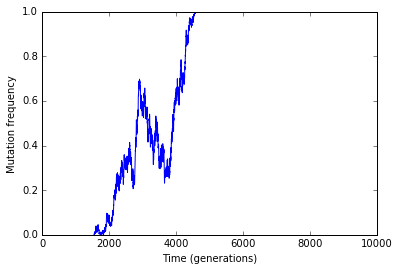

In [5]:
#Frequency trajectories of fixations
fig = plt.figure()
ax = plt.subplot(111)
plt.xlabel("Time (generations)")
plt.ylabel("Mutation frequency")
ax.set_xlim(traj[0]['generation'].min(),traj[0]['generation'].max())
for i in mpos:
    plt.plot(traj[0][traj[0]['pos']==i]['generation'],traj[0][traj[0]['pos']==i]['freq'])

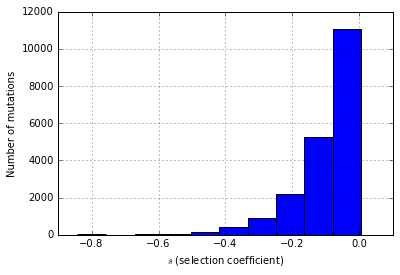

In [6]:
#Let's get histogram of effect sizes for all mutations that did not fix
fig = plt.figure()
ax = plt.subplot(111)
plt.xlabel(r'$s$ (selection coefficient)')
plt.ylabel("Number of mutations")
mfreq[mfreq['freq']<1.0]['esize'].hist()

## Reducing the memory footprint
In cases of long simulations and/or large mutation rates and/or large population sizes, it can take a lot of RAM to track mutation frequencies.

However, you do not have to keep all frequencies in memory!

Let's do something better, and store them every 1,000 generations to an h5 file.

In [7]:
#Let's redo the simulation above, but with different variables, etc.
rng2= fp.GSLrng(201)
popsizes = np.array([1000],dtype=np.uint32)
##Now, popsizes will be 10x smaller...
popsizes=np.tile(popsizes,1000)
#Evolve the first 'N' generations:
pops2 = fp.popvec(1,1000)
traj2 = [pd.DataFrame(i) for i in fp.evolve_regions_track(rng2,pops,popsizes[0:],0.001,0.001,0.001,nregions,sregions,rregions,1)]

#open an hdf 5 file:
hdf = pd.HDFStore("trajectories.h5",'w')
hdf.open()
#Write the first set of trajectories
hdf.append('traj',traj2[0])

In [8]:
#Evolve for another 9N generations
#Update the h5 file after each chunk, and then clear out trajectories
for i in range(9):
    traj2 = [pd.DataFrame(i) for i in fp.evolve_regions_track(rng2,pops2,popsizes[0:],0.001,0.001,0.001,nregions,sregions,rregions,1)]
    hdf.append('traj',traj2[0])

##Close the h5 file
hdf.close()

In [9]:
##Get the data frame out
traj2 = pd.read_hdf('trajectories.h5','traj')

In [10]:
len(traj[0])==len(traj2)

False

In [11]:
mfreq2 = traj2.groupby(['pos','esize']).max().reset_index()
#Print out info for all mutations that hit a frequency of 1 (e.g., fixed)
mfreq2[mfreq2['freq']==1]

,pos,esize,freq,generation


See, no fixations this time!

### Conclusion

You can run the simulation in chunks to save RAM, but you won't get the same result because this method uses the RNG differently.